In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import PCA

In [20]:
input_file_Path= input("Enter the file name:")

# input_file_Path ="cho.txt"
filedata = np.loadtxt(input_file_Path, delimiter="\t")
sigma = float(input("Enter the sigma value: "))
data = filedata[:,2:]
k = int(input("Enter the no of centroids: "))
initial = eval(input("Enter GeneID for initial clusters: "))

Enter the file name:iyer.txt
Enter the sigma value: 0.8
Enter the no of centroids: 5
Enter GeneID for initial clusters: []


In [21]:
def compute_distance(x,y,sig):
    norm = np.linalg.norm(x-y)
    dist = norm * norm
    return np.exp(- dist / (sig * sig))

In [27]:
def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

In [28]:
#computation of similarity matrix
result = np.zeros((data.shape[0],data.shape[0]))
nData = data.shape[0]
for i in range(0,nData):
    for j in range(0, nData):
        weight = RbfKernel(data[i], data[j], sigma)
        result[i,j] = weight
        
#print(result.shape)        
similarityMatrix=result

#degree matrix computation
diag = np.array(similarityMatrix.sum(axis=1)).ravel()
#print(diag.shape)
degreeMatrix = np.diag(diag)

#laplacian matrix computation
laplacianMatrix = degreeMatrix - similarityMatrix

values, vectors = np.linalg.eig(laplacianMatrix)
#print(vectors.shape)

# sort these based on the eigenvalues
vectors = vectors[:,np.argsort(values)]
values = values[np.argsort(values)]
maxvalue = 0;
index = 0;
for i in range(1,len(values.tolist())):
    if(values[i]-values[i-1] > maxvalue):
        maxvalue = values[i]-values[i-1]
        index = i
                
print("Index-----", index,maxvalue)


initial = []
maxIterations = 300
data = np.array(vectors[:,0:index+1])
truelabels = filedata[:,1]
truelabels = np.reshape(truelabels, (len(truelabels),1))


## Initialize Centroids
if(len(initial)==k):
    initial=[i-1 for i in initial]
    centroids= data[initial,:]
else:
    print("Using random centroids.")
    perm=np.random.permutation(len(data))
    centroids= data[perm[0:k]]


Index----- 226 7.749859837510982
Using random centroids.


In [29]:
#K-Means algorithm
iterations = 0
prevCentroid = np.zeros(shape = centroids.shape)
dataCluster = np.concatenate((np.zeros(shape = (data.shape[0],1)), data), axis = 1)
clusterID = np.zeros(shape = (data.shape[0], 1))
while((np.linalg.norm(prevCentroid-centroids)!=0) and (iterations<maxIterations)):
    prevCentroid = np.copy(centroids)
    for i in range(len(dataCluster)):
        dist = np.linalg.norm(dataCluster[i,1:] - centroids, ord=2, axis=1)
        dataCluster[i][0] = np.argmin(dist)
        clusterID[i][0] = dataCluster[i][0]
    for i in np.unique(dataCluster[:,0]):
        centroids[int(i)] = dataCluster[dataCluster[:,0] == int(i)].mean(0)[1:]
    iterations += 1
clusterIDMatrix = []
for i in clusterID:
    clusterIDMatrix.append([i[0]+1])
clusterID =np.array(clusterIDMatrix)

In [30]:
#external coefficients computation
groundTruth = (truelabels.T == truelabels).astype(int)
clustering = (clusterID.T == clusterID).astype(int)
table = (groundTruth == clustering)
randIndex = table.sum()/table.size
table1 =  groundTruth & clustering
table2 = groundTruth | clustering
JaccardIndex = table1.sum()/table2.sum()

sigma  0.8
Iterations:  2
Jaccard coefficient: 0.15554982381210672
Random index: 0.16708132396020786
labels
1.0    513.0
2.0      1.0
3.0      1.0
4.0      1.0
5.0      1.0
Name: count, dtype: float64


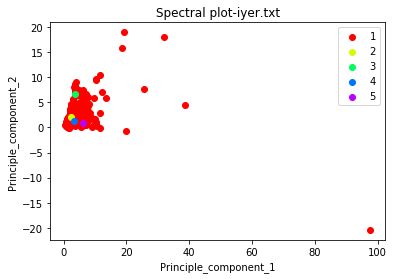

In [31]:
data = filedata[:,2:]
#PCA for plotting
X=(data - data.mean(0))
# Covariance matrix
S=(1/(X.shape[0]))*X.T.dot(X)
#EigenVectors
eigen_vectors=np.linalg.eig(S)[1]
pca_plotData=data.dot(eigen_vectors[:,0:2])
df_pca = pd.DataFrame(dict(x=list(pca_plotData[:,0]), y=list(pca_plotData[:,1]), labels=clusterID[:,0]))


print("sigma ", sigma)
print("Iterations: ",iterations)
print("Jaccard coefficient:",JaccardIndex)
print("Random index:",randIndex)

print(df_pca['labels'].groupby(df_pca['labels']).describe()['count'])

colors = plt.cm.get_cmap('hsv', k+1)
#  Plotting the dataframe with labels
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(k):
    ax1.scatter(df_pca[df_pca['labels']== i+1 ]['x'], df_pca[df_pca['labels']==i+1]['y'], color=colors(i), label=i+1)
plt.legend()
plt.title("Spectral plot-"+input_file_Path)
plt.xlabel("Principle_component_1")
plt.ylabel("Principle_component_2")

plt.show()
